# Satellite Image Land Cover Segmentation
Cameron Braatz - 12.05.2024

CU-Boulder - Machine Learning

Saving prediction_thumbnail.png to prediction_thumbnail (1).png


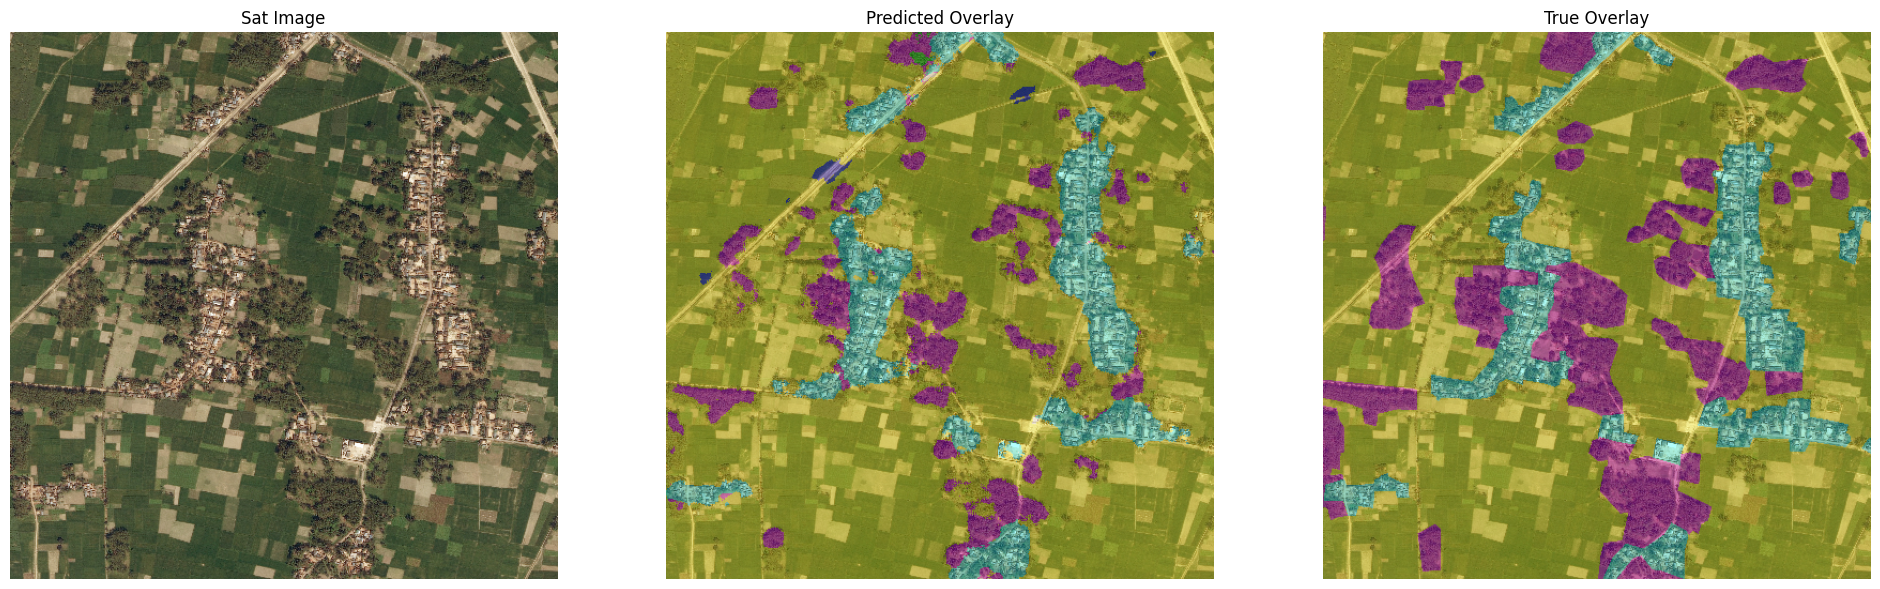

In [71]:
from google.colab import files
from IPython.display import display
from IPython.display import Image as Im

files.upload()
display(Im('/content/prediction_thumbnail.png'))

## Overview
The following notebook prepares and trains a machine learning model to perform multi-class segmentation to predict land cover types from a set of satellite images. This dataset focuses on the detection of urban, agricultural, rangeland, forest, water, barrn and unknown land covers.

Traditionally, this task was accomplished through time-intensive manual inspection of aerial/satellite imagery. Experts performing this analysis were trained to identify and differentiate the 'shape, size, pattern, color, tone, texture, shadows, geographic context and association' of the land covers classes exhibited in the landscape (USGS).

### Data Source
The dataset used for this project, <a href="https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset/data">DeepGlobe Land Cover Classification Dataset</a>, was sourced from Kaggle. The dataset is comprised of:
- 803 training images and masks
- 171 validation images
- 172 test images
- `metadata.csv` image/mask index file
- `classes.csv` land cover class encoding

### Outline
The basic structure of the following notebook is as follows:
- Exploratory Data Analysis
  - Accessing the Data
  - Splitting Train/Test Sets
  - Visual Inspection
- Image Preprocessing
  - Testing the `Image` class
  - Applying Augmentations
- Mask Preprocessing
  - Testing the `Mask` class
  - Visualizing Class Distribution
  - Applying Augmentations
- Data Preparation
  - Image/Mask Processing
  - Analyzing Training Distribution
  - Model Training
- Reflection

## Setting up the Environment
The first section entails importing all of the libraries, downloading/unpacking the data remotely from Kaggle. This process ensures our runtime environment has what it needs to train and test our model.

In [2]:
# data manipulation...
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from IPython.display import display
from tqdm.keras import TqdmCallback
from PIL import Image as PILImage

# tensor flow keras/cnn...
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, Dropout, Dense, AveragePooling2D, MaxPooling2D, Flatten, Activation

# vision transformers
from transformers.models.vit.feature_extraction_vit import ViTFeatureExtractor
from transformers import ViTForImageClassification, TrainingArguments, Trainer

# saving models and data
import joblib

# OS for navigation and environment set up
import os

# tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# splitting datasets
from sklearn.model_selection import train_test_split

# random
import random

# progress bar
from tqdm import tqdm

# model import

from keras.models import load_model

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
files.upload() # kaggle.json...

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cambraatz","key":"30961088bd1792504b5acdc44a1b48e4"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list

In [5]:
!kaggle datasets download -d balraj98/deepglobe-land-cover-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
100% 2.73G/2.74G [00:17<00:00, 164MB/s]
100% 2.74G/2.74G [00:17<00:00, 165MB/s]


In [76]:
!unzip deepglobe-land-cover-classification-dataset.zip > /dev/null

replace class_dict.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Exploratory Data Analysis (EDA)
## Accessing the Data
The process below involves opening the two CSV files that provide insights into the data we will be exploring:

`metadata.csv` contains unique image ID's shared by a satellite image and mask image pair, as well as thier respective 'split' classification. The 'images' in our case are the relative file paths to the real image and mask files.

In [7]:
''' base_dir = "/kaggle/input/deepglobe-land-cover-classification-dataset" '''

# read in metadata and preview...
metadata = pd.read_csv("metadata.csv") #os.path.join(base_dir, "metadata.csv"))
display(metadata.sample(5))

# read in classes and preview...
classes = pd.read_csv("class_dict.csv") #os.path.join(base_dir, "class_dict.csv"))
display(classes)

image_id  split        sat_image_path              mask_path
957    905310  valid  valid/905310_sat.jpg                    NaN
581    733758  train  train/733758_sat.jpg  train/733758_mask.png
912    671274  valid  valid/671274_sat.jpg                    NaN
240    354033  train  train/354033_sat.jpg  train/354033_mask.png
88     194156  train  train/194156_sat.jpg  train/194156_mask.png

name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0

`class_dict.csv` contains the mask color encoding, which encodes 7 unique land cover types and their corresponding color blocking. Meaning that each land cover type has a unique permutation of full-saturation (R,G,B) values, see below:
<br><br>

| Land Cover | Color Name | RGB Value | Color Block |
|------------|------------|-----------|-------------|
| Urban | Cyan | rgb(0,255,255) | <b><font color="cyan">==========</font></b> |
| Agricultural | Yellow | rgb(255,255,0) | <b><font color="yellow">==========</font></b> |
| Range | Magenta | rgb(255,0,255) | <b><font color="magenta">==========</font></b> |
| Forested | Green | rgb(0,255,0) | <b><font color="green">==========</font></b> |
| Water | Blue | rgb(0,0,255) | <b><font color="blue">==========</font></b> |
| Barren | White | rgb(255,255,255) | <b><font color="white">==========</font></b> |

<br>

### Data Format
We see above that we are dealing with satellite images and masks stored using the `.jpg` and `.png` image file types. During the preprocessing stage, these image files will be broken into pixel arrays to access the RGB tuples encoding each pixel.

Images are dimensioned 2448px by 2448px, when accessed as an array the satellite images will be an array sized 2448x2448x3. This added depth of three encodes the RGB values; which in the case of satellite imagery will range $0 < R,G,B < 255$. Recall that the mask files should be color blocked according to the RGB mapping seen in the classes dataframe above, ideally we should be seeing the range of RGB values for masking cells to be $R,G,B = 0\  ||\ R,G,B = 255$.

## Splitting Train/Test sets
As prefaced above, the `metadata.csv` file contains predefined training and testing splits. Immediately of note, the testing data split *does not include masks*. Unfortunately this makes it difficult to test our model's performance.

We can keep this data, predict on it and assessment model performance by visual inspection; or we can split the training data into a training and validation set where we can explicitly test its accuracy.

In [8]:
# split metadata (ie: file paths) into training files...
train_data_paths = metadata[metadata['split'] == 'train'].drop(['split'], axis=1)
print("train_data_paths size: ", train_data_paths.shape)
display(train_data_paths.head())

# and testing files...
test_data_paths = metadata[metadata['split'] == 'test'].drop(['split'], axis=1)
print("test_data_paths size: ", test_data_paths.shape)
display(test_data_paths.head())

train_data_paths size:  (803, 3)


image_id        sat_image_path              mask_path
0    100694  train/100694_sat.jpg  train/100694_mask.png
1    102122  train/102122_sat.jpg  train/102122_mask.png
2     10233   train/10233_sat.jpg   train/10233_mask.png
3    103665  train/103665_sat.jpg  train/103665_mask.png
4    103730  train/103730_sat.jpg  train/103730_mask.png

test_data_paths size:  (172, 3)


image_id       sat_image_path mask_path
974    100877  test/100877_sat.jpg       NaN
975    103215  test/103215_sat.jpg       NaN
976    103742  test/103742_sat.jpg       NaN
977    110224  test/110224_sat.jpg       NaN
978    112946  test/112946_sat.jpg       NaN

## Visual Inspection
For now, we are only interested in getting more familiar with the type of training we will need to do. The plotting function below allows for direct visual comparison between the input images, the color blocked land cover mask and how they encode one another.

standard image/mask shape: (2448, 2448, 3)


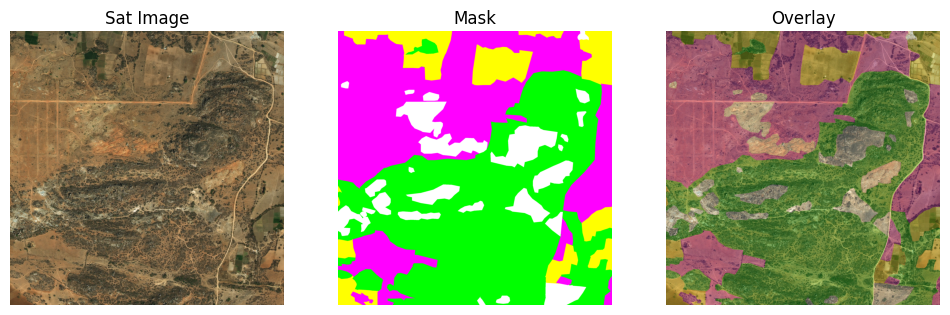

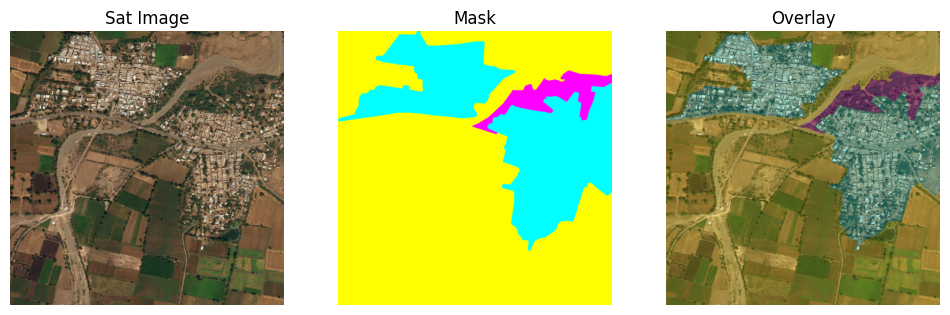

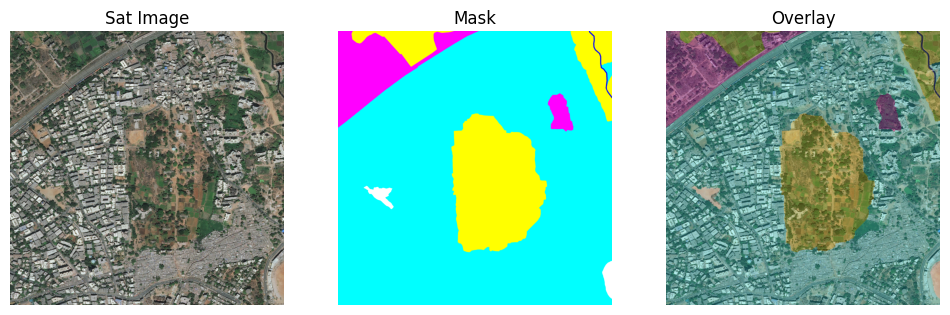

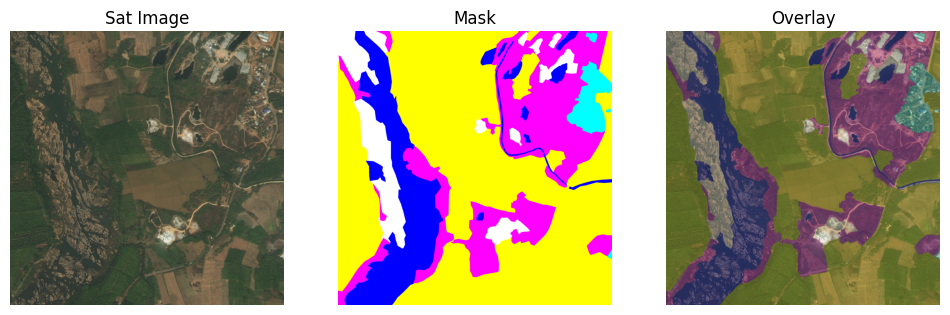

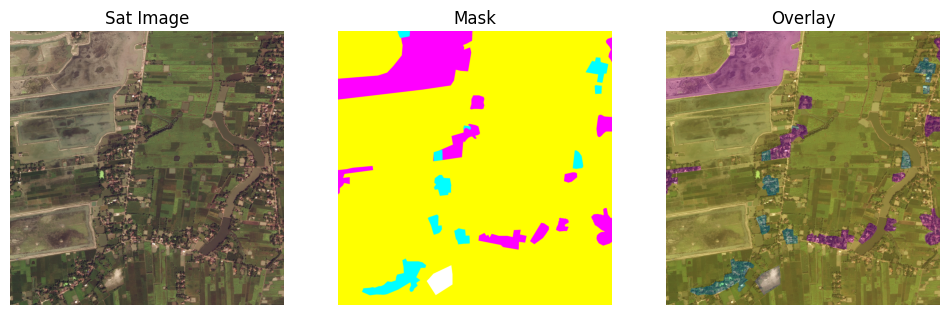

In [9]:
# helper to plot satellite, mask and overlay in sequence...
def plot_overlay(index_img=0, data_path=train_data_paths):
  # load the image and mask using our training data...
  img = plt.imread(data_path['sat_image_path'][index_img])
  mask = plt.imread(data_path['mask_path'][index_img])

  # create a figure and axes...
  fig, axs = plt.subplots(1,3, figsize=(12,10))

  # display the satellite image...
  axs[0].imshow(img)
  axs[0].set_title("Sat Image")
  axs[0].axis('off')

  # display the mask...
  axs[1].imshow(mask)
  axs[1].set_title("Mask")
  axs[1].axis('off')

  # display the mask over the sat image...
  axs[2].imshow(img)
  axs[2].imshow(mask, alpha=0.2)
  axs[2].set_title("Overlay")
  axs[2].axis('off')

  # show the plot...
  plt.show()

img = plt.imread(train_data_paths['sat_image_path'][0])
print(f"standard image/mask shape: {img.shape}")

cherry_picks = [161,348,482,423,305]

for i in cherry_picks:
  plot_overlay(index_img=i)

It might be helpful to get acquainted with the land covers the model will aim to classify. Refer to these images to get familiar with the particular patterns, textures, colors, etc. exhibited by each class.

Please note that the images selected for visualization were hand-selected for their overwhelming proportion of each land cover (excluding *unknown*), and are not necessarily indicative of the average image samples. While the images below are outliers, they are quite indicative of the overall composition of the training images.

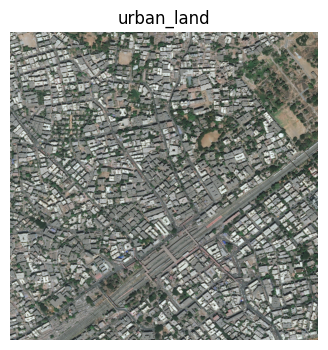

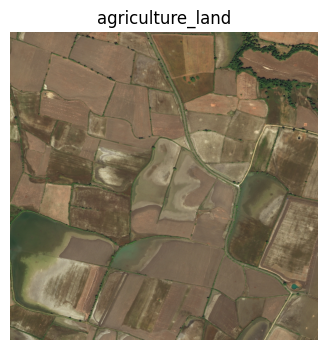

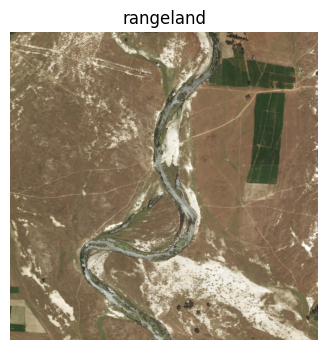

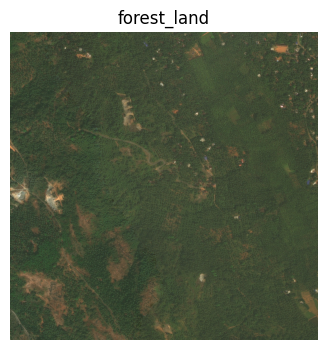

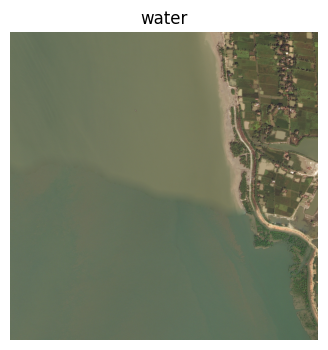

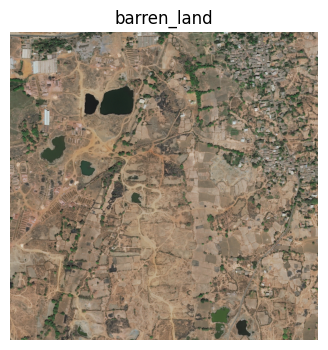

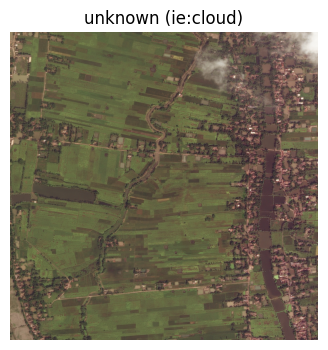

In [10]:
land_covers = {
    "urban_land": 79,
    "agriculture_land": 101,
    "rangeland": 169,
    "forest_land": 74,
    "water": 290,
    "barren_land": 115,
    "unknown (ie:cloud)": 329,
  }

for key, val in land_covers.items():
  img = plt.imread(train_data_paths['sat_image_path'][val])

  plt.figure(figsize=(4,4))
  plt.imshow(img)
  plt.title(key)
  plt.axis('off')
  plt.show()

# Image Pre-Processing
We are sticking to a object-oriented approach to managing our data resources and start by defining the `Image` class definition. Meant to generate a new object for each image processed, pertinent information is held contained within for easy access throughout the course of training, testing and visualization.

Our standard image processing functions include loading, resizing and plotting. Given our images are 2448px by 2448px it was in our best interest to downsize the images for the sake of our study, training our model on full size images would undoubtedly be computationally taxing. At least the first few iterations will work from images 25% of the original size as a *proof of concept*.

Additional class functions, `subdivide_image` and `reconstruct_image`, perform what is known as a tiling procedure. Used primarily with large images or small object detection, a high resolution image is broken into a grid of smaller images that are easier to process. These smaller image chunks are run through the image classifier and aggregated back to form a composite prediction.

In [11]:
# image class definition and helper functions...
class Image:
  # initialize class definition...
  def __init__(self, image_path, image_shape=(2448, 2448, 3)):
    self.image_path = image_path
    self.image = self._load_image(image_path)
    self.image_shape = image_shape
    self.tile_dim = int(image_shape[0] / 9)  # default tile dim is based on image shape
    self.tiles = None
    self.shape = self.image.shape

    # ensure TensorFlow uses GPU (if available)...
    self.device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

  # load in our image...
  def _load_image(self,img_path):
    return plt.imread(img_path)

  # resize image using tf techniques...
  def resize_image(self, target_size=(512, 512)):
    with tf.device(self.device):
        image_tensor = tf.convert_to_tensor(self.image, dtype=tf.float32)
        resized_image = tf.image.resize(image_tensor, target_size)
        self.image = resized_image.numpy().astype(np.uint8)  # Convert back to NumPy for consistency
    self.image_shape = target_size

  # procedure to divide the image into tiles...
  def subdivide_image(self, tile_shape=None, show_image=False):
    tile_shape = tile_shape or (self.tile_dim, self.tile_dim)
    image_shape = self.image.shape
    n_rows = image_shape[0] // tile_shape[0]
    n_cols = image_shape[1] // tile_shape[1]

    sub_images = []
    if show_image:
      fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6, 6))

    for i in range(n_rows):
      for j in range(n_cols):
        sub_image = self.image[i * tile_shape[0]:(i + 1) * tile_shape[0], j * tile_shape[1]:(j + 1) * tile_shape[1], :]
        sub_images.append(sub_image)
        if show_image:
            ax[i, j].imshow(sub_image)
            ax[i, j].axis('off')

    if show_image:
      fig.suptitle('Subdivided Images')
      plt.show()

    self.tiles = np.array(sub_images)
    return self.tiles

  # recompile the tiles into the original image format...
  def reconstruct_image(self, cropped_images=None, tile_shape=None, image_shape=None, show_image=False):
    cropped_images = cropped_images or self.tiles
    tile_shape = tile_shape or (self.tile_dim, self.tile_dim)
    image_shape = image_shape or self.image_shape
    new_image = np.zeros(image_shape)
    n_rows = image_shape[0] // tile_shape[0]
    n_cols = image_shape[1] // tile_shape[1]

    for i in range(n_rows):
      for j in range(n_cols):
        sub_image = cropped_images[i * n_rows + j]
        new_image[i * tile_shape[0]:(i + 1) * tile_shape[0], j * tile_shape[1]:(j + 1) * tile_shape[1], :] = sub_image / 255

    if show_image:
      plt.figure(figsize=(6, 6))
      plt.axis('off')
      plt.title('Re-Constructed Image')
      plt.imshow(new_image)
      plt.show()

    return new_image

  def augment_image(self, image, augmentations):
    for aug in augmentations:
        image = aug(image)  # Apply each augmentation
    self.image = image  # Update self.image with the augmented version
    return image  # Optional: Return augmented image if needed

  # plot the image for visual review...
  def plot_image(self, title):
    plt.figure(figsize=(6,6))
    plt.imshow(self.image)
    plt.title(title)
    plt.axis('off')
    plt.show()

## Testing the `Image` class
An arbitrary image is chosen to test our class definition to be sure it can successfully pre-process an image. Particularly we want to be sure we can split our image into a grid of sub-images, and then recompile it again.

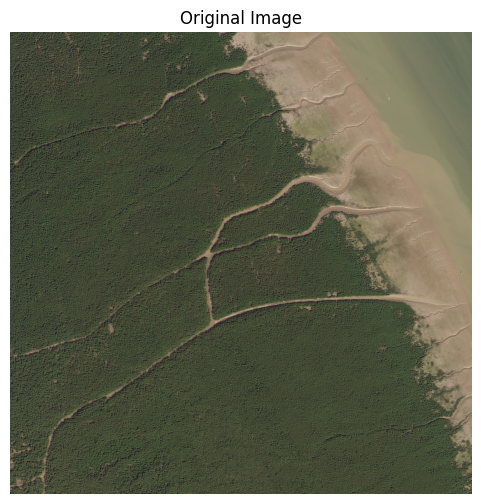

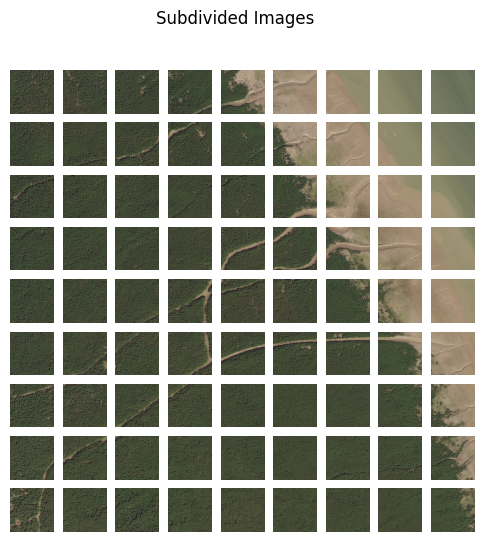

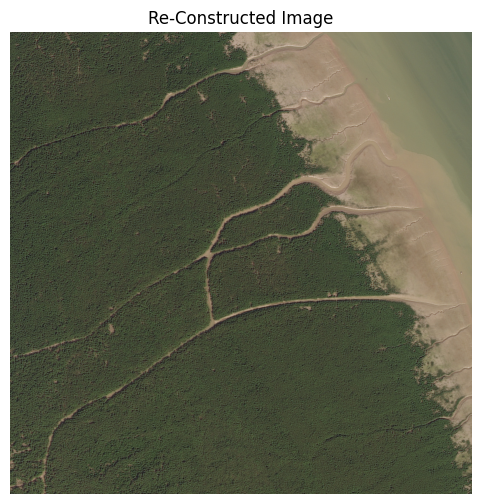

In [12]:
# define global image dimensions, likely need to downsize for training...
IMAGE_SHAPE = (2448,2448,3)

# sample arbitrary training image and initialize as Image object...
sample_path = train_data_paths['sat_image_path'][771]
image_obj = Image(sample_path, image_shape=IMAGE_SHAPE)

# demonstrate image tiling...
image_obj.plot_image('Original Image')
tiles = image_obj.subdivide_image(show_image=True)
reconstructed_image = image_obj.reconstruct_image(show_image=True)

### Applying Augmentations
Out of the box TensorFlow image augmentations can also be applied to our images to increase the diversity of our training set.

It is important to note that whatever transformations applied to the satellite image, must also be performed on the mask image as well. Additionally, the mask files must be protected from augmentations like brightness and contrast changes that will impact the color mapping.


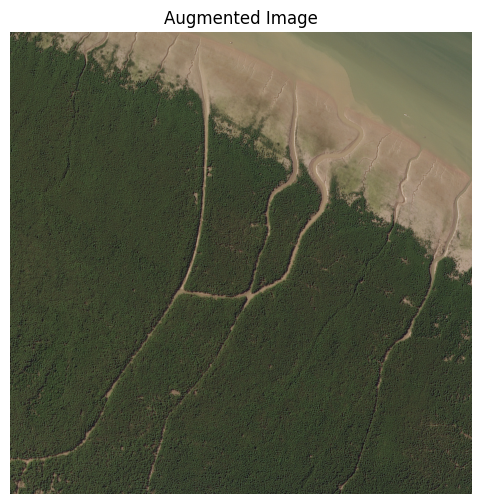

In [13]:
# define a set of custom augmentations...
augmentations = [
  lambda x: tf.image.random_flip_left_right(x),
  lambda x: tf.image.random_flip_up_down(x),
  lambda x: tf.image.rot90(x, k=np.random.randint(1, 4)),
  lambda x: tf.image.random_brightness(x, max_delta=0.2),
  lambda x: tf.image.random_contrast(x, lower=0.8, upper=1.2)
]

# apply and visualize augmented image...
image_obj.augment_image(image_obj.image, augmentations)
image_obj.plot_image('Augmented Image')

Ultimately I was able to tile my images, but the additional processing and aggregation proved to be logistically and computationally taxing with this data. While many agree that this approach is effective, I hypothesize that much of the land cover detail may still be perceived on a macro-level.

Instead, I opted to simplify and train the model with whole image processing on scaled down images, 512px x 512px, in lieu of processing tiled, full-size images at 2448px x 2448px dimensionality. This significantly speeds up pre-processing and training times, but also operations from here on out.

## Mask Pre-Processing
Just as with the image class definition, we define the `Mask` object below to organize the data pertaining to individual land cover masks. It also has the standard image processing function like loading, resizing and plotting...however, it also holds the logic for one hot encoding the land cover masks so that our model can process them.

In order to correctly one hot encode the masks, we first need to normalize their color values. The data source indicates that not all pixel RGB values will be pure, ie: not exclusively 0 or 255. By normalizing the RGB array, we first ensure it's values match the intended range before binarizing with a threshold of 128 per the source's recommendation. Any red, green or blue values $< 128$ are assigned a 0 value and any values $\geq 128$ are assigned 255.

In [14]:
# mask class definition and helper functions...
class Mask:
  # initialize class object...
  def __init__(self, mask_path, mask_shape=(2448, 2448, 3)):
    self.mask_path = mask_path
    self.class_colors = { # can this be removed to lighten it up???
        (0, 255, 255): "urban_land",
        (255, 255, 0): "agriculture_land",
        (255, 0, 255): "rangeland",
        (0, 255, 0): "forest_land",
        (0, 0, 255): "water",
        (255, 255, 255): "barren_land",
        (0, 0, 0): "unknown",
    }
    self.color_indices = { # can this be removed to lighten it up???
        (0, 255, 255): 0,  # urban_land
        (255, 255, 0): 1,  # agriculture_land
        (255, 0, 255): 2,  # rangeland
        (0, 255, 0): 3,    # forest_land
        (0, 0, 255): 4,    # water
        (255, 255, 255): 5, # barren_land
        (0, 0, 0): 6       # unknown
    }

    # mandatory processing...
    self.mask = self.load_mask(mask_path)
    self.normalized_mask = self.normalize_mask(self.mask)
    self.unique_colors = self.find_unique_colors()
    self.ohe = self.one_hot_encode()
    self.classes = self.map_colors_to_classes()

    # optional processing...
    self.class_counts = None
    self.shape = self.mask.shape
    self.mask_shape = mask_shape
    self.tile_dim = int(mask_shape[0] / 9)  # Default tile dim is based on image shape
    self.tiles = None

  # load the mask image file as np array...
  def load_mask(self,mask_path):
    return plt.imread(mask_path)

  # resize the mask to a given size...
  def resize_mask(self, target_size=(512, 512)):
    self.normalized_mask = cv.resize(self.normalized_mask, target_size, interpolation=cv.INTER_AREA)
    self.ohe = self.one_hot_encode()

  # normalize the mask to range [0-255] and binarize to threshold of 128...
  def normalize_mask(self,mask):
    # ensure proper range...
    if mask.max() <= 1.0:
        mask = (mask * 255).astype(np.uint8)
    else:
        mask = mask.astype(np.uint8)

    # binarize the mask RGB values...
    mask[mask >= 128] = 255
    mask[mask < 128] = 0

    return mask

  # find unique colors from mask for validation...
  def find_unique_colors(self):
    return np.unique(self.normalized_mask.reshape(-1, 3), axis=0)

  # map the unique colors to their classes...
  def map_colors_to_classes(self):
    found_classes = {}
    for color in self.unique_colors:
        color_tuple = tuple(color)
        found_classes[color_tuple] = self.class_colors.get(color_tuple, "unknown")
    return found_classes

  # one hot encode each pixel to a color index...
  def one_hot_encode(self):
    # initialize blank mask array...
    height, width, _ = self.normalized_mask.shape
    index_mask = np.zeros((height, width), dtype=np.int32)

    # map one hot encodings into array for training...
    for color, idx in self.color_indices.items():
        match = np.all(self.normalized_mask == np.array(color), axis=-1)
        index_mask[match] = idx

    # attempt to bring more GPU optimization to this...
    index_mask_tensor = tf.convert_to_tensor(index_mask, dtype=tf.int32)
    one_hot_mask = tf.one_hot(index_mask_tensor, len(self.color_indices))

    # ensure output is still in numpy format...
    return one_hot_mask.numpy()

  # divide mask into tiles and store subimages...
  def subdivide_mask(self, tile_shape=None, show_mask=False):
    tile_shape = tile_shape or (self.tile_dim, self.tile_dim)
    mask_shape = self.mask.shape
    n_rows = mask_shape[0] // tile_shape[0]
    n_cols = mask_shape[1] // tile_shape[1]

    sub_masks = []
    if show_mask:
        fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6, 6))

    for i in range(n_rows):
        for j in range(n_cols):
            sub_mask = self.mask[i * tile_shape[0]:(i + 1) * tile_shape[0], j * tile_shape[1]:(j + 1) * tile_shape[1]]
            sub_masks.append(sub_mask)
            if show_mask:
                ax[i, j].imshow(sub_mask, cmap='gray')
                ax[i, j].axis('off')

    if show_mask:
        fig.suptitle('Subdivided Masks')
        plt.show()

    self.tiles = np.array(sub_masks)
    return self.tiles

  # reconstruct a mask from its tiles...
  def reconstruct_mask(self, cropped_masks=None, tile_shape=None, mask_shape=None, show_mask=False):
    cropped_masks = cropped_masks or self.tiles
    tile_shape = tile_shape or (self.tile_dim, self.tile_dim)
    mask_shape = mask_shape or self.mask_shape
    new_mask = np.zeros(mask_shape)
    n_rows = mask_shape[0] // tile_shape[0]
    n_cols = mask_shape[1] // tile_shape[1]

    for i in range(n_rows):
      for j in range(n_cols):
        sub_mask = cropped_masks[i * n_rows + j]
        new_mask[i * tile_shape[0]:(i + 1) * tile_shape[0], j * tile_shape[1]:(j + 1) * tile_shape[1]] = sub_mask

    if show_mask:
      plt.figure(figsize=(6, 6))
      plt.axis('off')
      plt.title('Re-Constructed Mask')
      plt.imshow(new_mask, cmap='gray')
      plt.show()

    return new_mask

  # apply augmentations to the mask...
  def augment_mask(self, mask, augmentations):
    for aug in augmentations:
        mask = aug(mask)
    self.mask = mask
    return mask

  def plot_mask(self, title, overlay=None, size=(6,6)):
    plt.figure(figsize=size)
    if (overlay):
      img = plt.imread(overlay)
      plt.imshow(img)
      plt.imshow(self.mask, alpha=0.2)
    else:
      plt.imshow(self.mask)
    plt.title(title)
    plt.axis('off')
    plt.show()

## Testing the `Mask` class
Once defined, we can test the classes ability to process a single mask file. Just as with the images, a new `Mask` object will be generated for each mask file processed...making it a priority to keep the object lightweight.

The contained `.calculate_class_distribution` and `.plot_class_histogram` class functions were removed and converted to standalone functions (see below) to be called only during preliminary testing. Additionally, this slims down our `Mask`'s and protects them from excessive and unnecessary computation. See below for their logic and implementation.

Our preliminary testing shows that the class processes the land cover mask, normalizing the RGB colors into clean 0's and 255's to be one hot encoded. The results of this process can be seen below, where unique colors and classes were identified and a preview of the encoding are logged.

In [15]:
# iterate tensors to gather pixel counts for each class...
def calculate_class_distribution(mask, class_colors):
    class_counts = {name: 0 for name in class_colors.values()}
    normalized_mask_tensor = tf.convert_to_tensor(mask.normalized_mask, dtype=tf.uint8)

    for color, class_name in class_colors.items():
        color_tensor = tf.constant(color, dtype=tf.uint8)
        match = tf.reduce_all(tf.equal(normalized_mask_tensor, color_tensor), axis=-1)

        # Count occurrences on GPU
        count = tf.reduce_sum(tf.cast(match, tf.int32)).numpy()
        class_counts[class_name] += count

    return class_counts

# visualize the class histogram...
def plot_class_histogram(class_counts, class_colors):
    # prepare colors and labels for the bars...
    bar_colors = [np.array(color) / 255.0 for color in class_colors.keys()]
    bar_labels = list(class_colors.values())
    bar_values = [class_counts[name] for name in bar_labels]

    plt.bar(bar_labels, bar_values, color=bar_colors)
    plt.xlabel("Classes")
    plt.ylabel("Pixel Count")
    plt.title("Class Distribution in Mask")
    plt.xticks(rotation=60)
    plt.show()

In [20]:
# load in mask and create Mask object...
mask_path = train_data_paths['mask_path'][161]
mask = Mask(mask_path)

# demonstrate class functions...
print(f"Unique colors:\n{mask.find_unique_colors()}\n")
print(f"Unique classes:\n{mask.classes}\n")
print(f"One hot encoded mask (first row):\n{mask.ohe[0]}\n")

Unique colors:
[[  0 255   0]
 [255   0 255]
 [255 255   0]
 [255 255 255]]

Unique classes:
{(0, 255, 0): 'forest_land', (255, 0, 255): 'rangeland', (255, 255, 0): 'agriculture_land', (255, 255, 255): 'barren_land'}

One hot encoded mask (first row):
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]



## Visualizing Class Distribution
While the class appears to be working just fine, it is best to do a visual inspection to avoid getting lost in the abstraction. The aforementioned plotting functions, `.calculate_class_distribution` and `.plot_class_histogram`, are called to compare the original mask to the perceived mask.

Ensuring that the set of perceived colors matches those seen in the mask and the relative distribution of each color is a good first step. Before moving on, I also ensure that my one hot encoded class distribution matches the color class distribution.

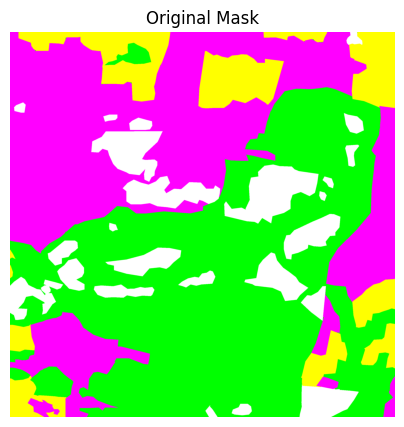

Class Distribution:
{'urban_land': 0, 'agriculture_land': 655965, 'rangeland': 2057871, 'forest_land': 2598728, 'water': 0, 'barren_land': 680140, 'unknown': 0}



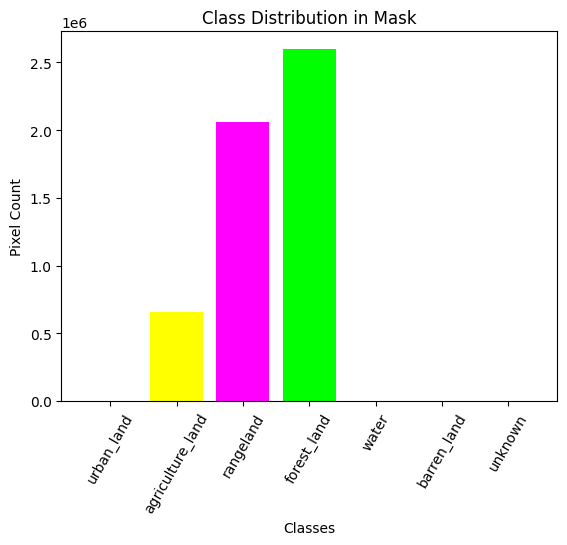

In [21]:
# visualize sample class distribution...
mask.plot_mask('Original Mask',size=(5,5))

# derive the class counts for plotting...
class_counts = calculate_class_distribution(mask, mask.class_colors)
print(f"Class Distribution:\n{class_counts}\n")

plot_class_histogram(class_counts, mask.class_colors)

### Applying Augmentations
Just as was done to the `Image` class, the mask images are also tested for their ability to be augmented. Flexibility in its implementation allows for easier model-tuning down the road.

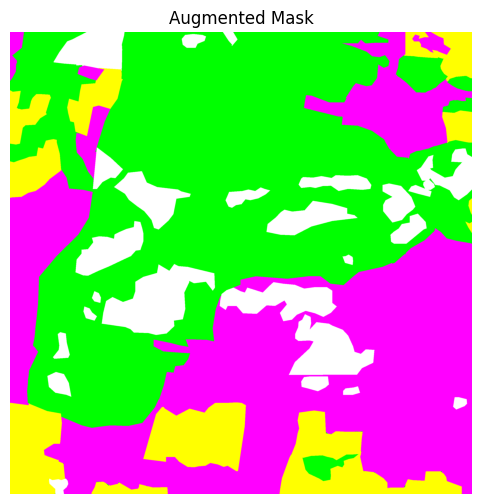

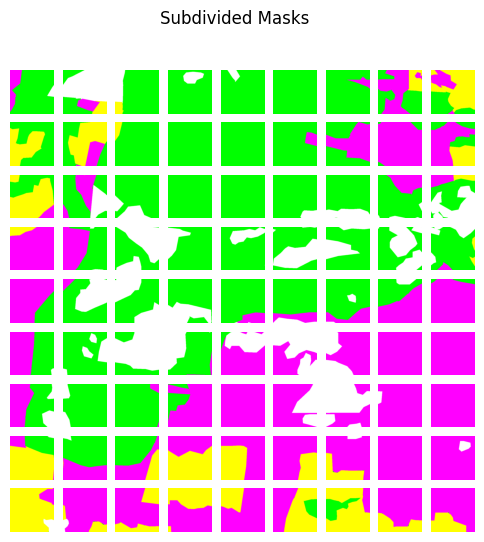

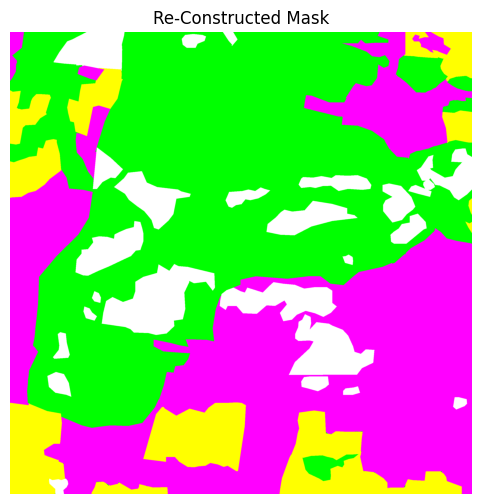

In [22]:
# do not manipulate brightness/contrast...
augmentations = [
  lambda x: tf.image.random_flip_left_right(x),
  lambda x: tf.image.random_flip_up_down(x),
  lambda x: tf.image.rot90(x, k=np.random.randint(1, 4)),  # Random 90-degree rotations
  #lambda x: tf.image.random_brightness(x, max_delta=0.2),
  #lambda x: tf.image.random_contrast(x, lower=0.8, upper=1.2)
]

# apply augmentations...
mask.augment_mask(mask.mask, augmentations)
mask.plot_mask('Augmented Mask')

# demonstrate image tiling...
tiles = mask.subdivide_mask(show_mask=True)
reconstructed_mask = mask.reconstruct_mask(show_mask=True)